In [1]:
import numpy as np
import pylops
import matplotlib.pyplot as plt
from pinnslope.utils import *
import colorcet as cc

Data shape: (201, 401)
LSinv (119, 211)
pwdout (211, 119)
(119, 211)
lowcmp (119, 211)
Cropped Data shape: (119, 211)
Rop (5064, 25109)
data_obs shape (24, 211)
data_obs shape (211, 24)
data_mask shape (211, 119)


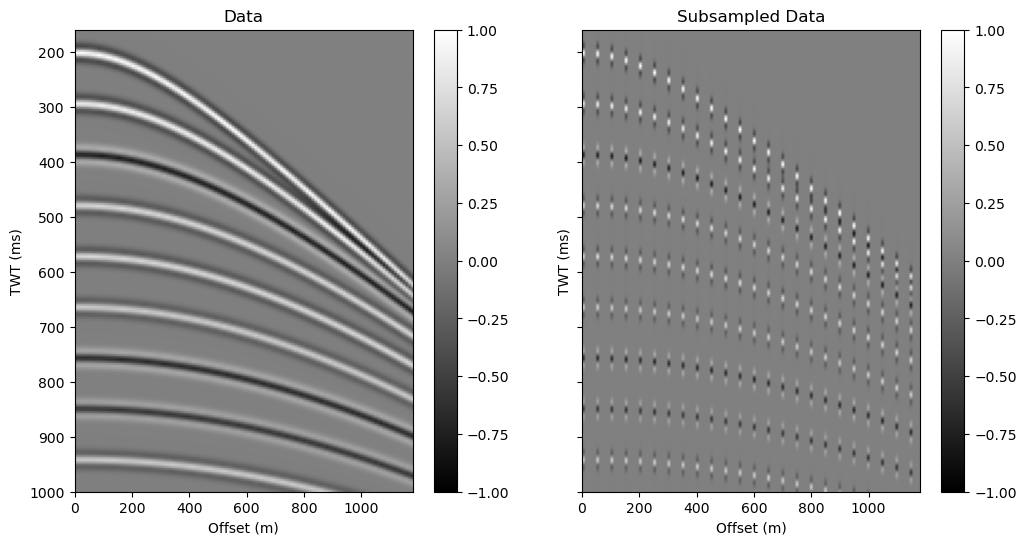

slope shape: (401, 201)
cropped slope shape: (211, 119)
slope_resh shape (25109, 1)


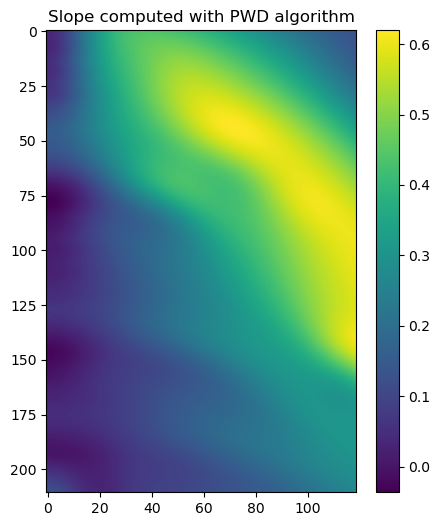

In [6]:
#Loading data:
path = '../data/synth_data/data_dense.npy'
data = np.load(path); print('Data shape:',data.shape)
lowcmp = np.load('../data/synth_data/Lf_datadense5.npy'); lowcmp=lowcmp.T
LSinv  = np.load('../data/Results/SynthResults/PWDLSinv.npy');  print('LSinv',LSinv.shape)
pwdout  = np.load('../data/Results/SynthResults/PWDPINNout.npy');pwdout=pwdout; print('pwdout',pwdout.shape)
doubleout  = np.load('../data/Results/SynthResults/DoublePINNout.npy');doubleout=doubleout.T; print(doubleout.shape)

# Choose subsampling:
minimum_velocity = 1500
nsub = 5

#crop the shot-gather for faster testing:
crop = True
# use an already computed slope
load_slope = True


if crop==True:
    
    # Defining crop params:    
    x_start=0; x_end=119; t_start=40; t_end=251
    data =data[ x_start:x_end, t_start:t_end ]
    lowcmp = lowcmp[ x_start:x_end, t_start:t_end ]; print('lowcmp',lowcmp.shape)
    print('Cropped Data shape:',data.shape)

    ox, dx, nx = x_start, 10, x_end;  ot, dt, nt = t_start, 0.004, t_end
    dim_x = int(nx-ox); dim_t = int(nt-ot)
    x = (np.arange(dim_x)+ ox)* dx
    x = np.reshape(x, (dim_x, 1) )
    t = ((np.arange(dim_t)+ ot) * dt)*1e3
    t = np.reshape(t, (dim_t, 1) )
    

else:
        # Defining full shot-gather params:
        ox, dx, nx = 0, 10, 201;  ot, dt, nt = 0, 0.004, 401
        dim_x = int(nx-ox); dim_t = int(nt-ot) 
        x = (np.arange(dim_x)+ ox)* dx
        x = np.reshape(x, (dim_x, 1) )
        t = ((np.arange(dim_t)+ ot) * dt)*1e3
        t = np.reshape(t, (dim_t, 1) )



# Create restriction operator:
traces_index = np.arange( dim_x ); traces_index_sub = traces_index[::nsub]
Rop = pylops.Restriction( [dim_x, dim_t] , iava=traces_index_sub, axis=0, dtype="float64" ); print('Rop',Rop.shape)

# Apply restriction operator:
data_obs = Rop * (data).ravel()
nxsub = int(np.ceil(data.shape[0]/nsub))
data_obs = data_obs.reshape(nxsub, dim_t)
print('data_obs shape',data_obs.shape)
data_obs = data_obs.T
print('data_obs shape',data_obs.shape)
# mask:
datamask = Rop.mask(data.ravel())
data_mask = datamask.data.T
print('data_mask shape',data_mask.shape)


# Display CMP and Trace selected:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

CMP = axs[0].imshow(data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('Data')
fig.colorbar(CMP, ax=axs[0])
axs[0].axis('tight')

CMP1 = axs[1].imshow(datamask.data.T, cmap='gray', vmin=-1, vmax=1, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title('Subsampled Data')
fig.colorbar(CMP1, ax=axs[1])
axs[1].axis('tight')
plt.show()


if load_slope == True:
    slope = np.load('../data/synth_data/SynthData5_low_freq_slope.npy')
    slope = (dim_x/dim_t)*slope.T
    print('slope shape:',slope.shape)
    if crop == True:
        slope = slope[ t_start:t_end , x_start:x_end]; print('cropped slope shape:',slope.shape)

    slope_resh = np.reshape(slope, (slope.shape[0]*slope.shape[1],1))
    print('slope_resh shape', slope_resh.shape)

    plt.figure(figsize=(5,6))
    plt.imshow(slope)
    plt.axis('tight')
    plt.title('Slope computed with PWD algorithm')
    plt.colorbar()
    plt.show()


### Intro figure for Synth data

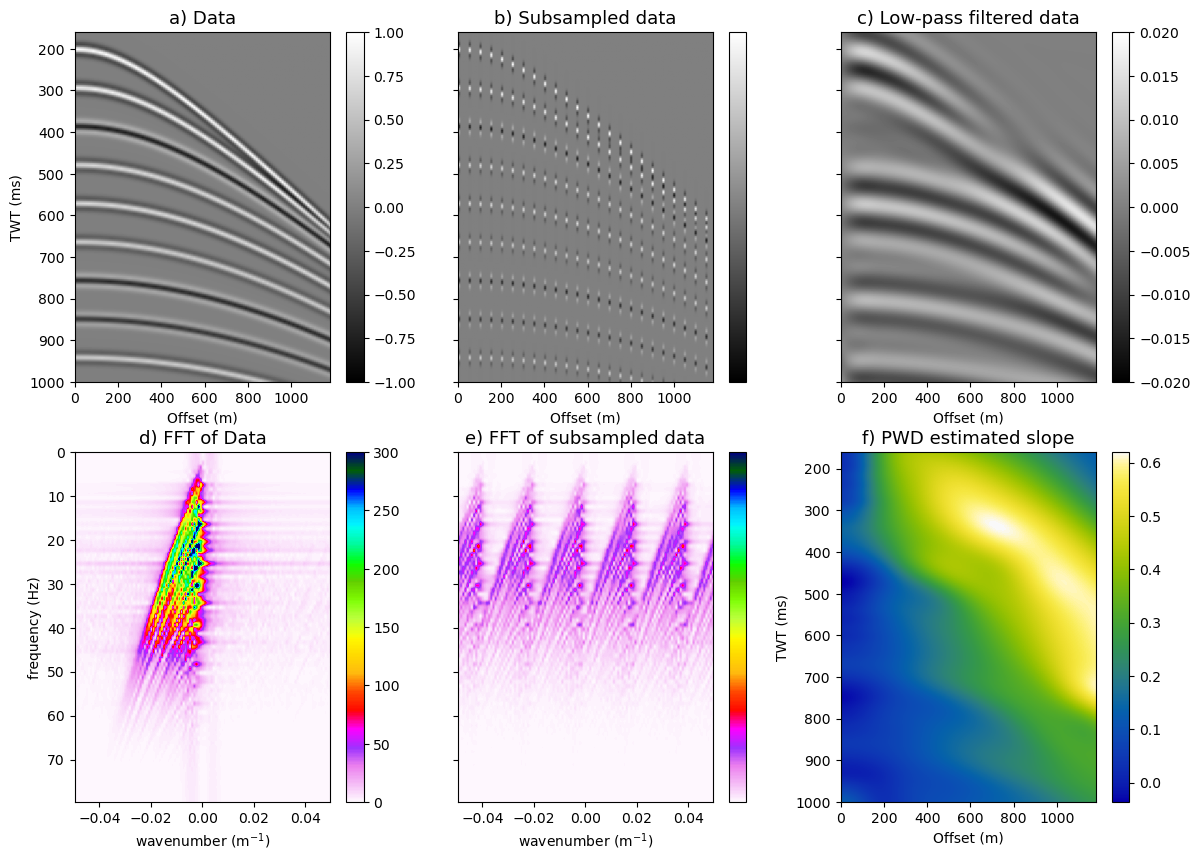

In [8]:
f, kx = np.fft.fftfreq(nt, dt), np.fft.fftfreq(nx, dx)

FFTorigin = np.fft.fft2(data[:,:].T)
FFTsub = np.fft.fft2(datamask.T[:,:])
limit_plot = 80

# Plotting difference with real
fig, axs = plt.subplots(2, 3, figsize=(14, 10))

vmin=-1; vmax=1

dat=axs[0][0].imshow(data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0][0].set_xlabel('Offset (m)')
axs[0][0].set_ylabel('TWT (ms)')
axs[0][0].set_title('a) Data', fontsize=13)
fig.colorbar(dat, ax=axs[0][0])
axs[0][0].axis('tight')

subdat=axs[0][1].imshow(datamask.data.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0][1].set_xlabel('Offset (m)')
axs[0][1].set_title('b) Subsampled data', fontsize=13)
fig.colorbar(subdat, ax=axs[0][1],ticks=[])
axs[0][1].set_yticklabels([])
axs[0][1].axis('tight')

LP=axs[0][2].imshow(lowcmp.T, cmap='gray', vmin=-0.02, vmax=0.02, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0][2].set_xlabel('Offset (m)')
axs[0][2].set_title('c) Low-pass filtered data', fontsize=13)
fig.colorbar(LP, ax=axs[0][2])
axs[0][2].set_yticklabels([])
axs[0][2].axis('tight')

FFTdata=axs[1][0].imshow(np.fft.fftshift(np.abs(FFTorigin[:limit_plot]), axes=1),cmap='gist_ncar_r', vmin=0, vmax=300, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[1][0].set_ylabel('frequency (Hz)')
axs[1][0].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)')
axs[1][0].set_title('d) FFT of Data', fontsize=13)
fig.colorbar(FFTdata, ax=axs[1][0])
axs[1][0].axis('tight')

FFTsubdata=axs[1][1].imshow(np.fft.fftshift(np.abs(FFTsub[:limit_plot]), axes=1), cmap='gist_ncar_r', vmin=0, vmax=300, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[1][1].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)',)
axs[1][1].set_title('e) FFT of subsampled data', fontsize=13)
axs[1][1].set_yticklabels([])
fig.colorbar(FFTsubdata, ax=axs[1][1], ticks=[])
axs[1][1].axis('tight')

slopePWD=axs[1][2].imshow(slope, cmap=cc.m_linear_bgyw_20_98_c66, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[1][2].set_title('f) PWD estimated slope',  fontsize=13)
axs[1][2].set_xlabel('Offset (m)')
axs[1][2].set_ylabel('TWT (ms)')
fig.colorbar(slopePWD, ax=axs[1][2])
axs[1][2].axis('tight')

#plt.savefig('/Introsynth.eps', dpi=100, bbox_inches='tight')
plt.show()

### Result figure for synth data

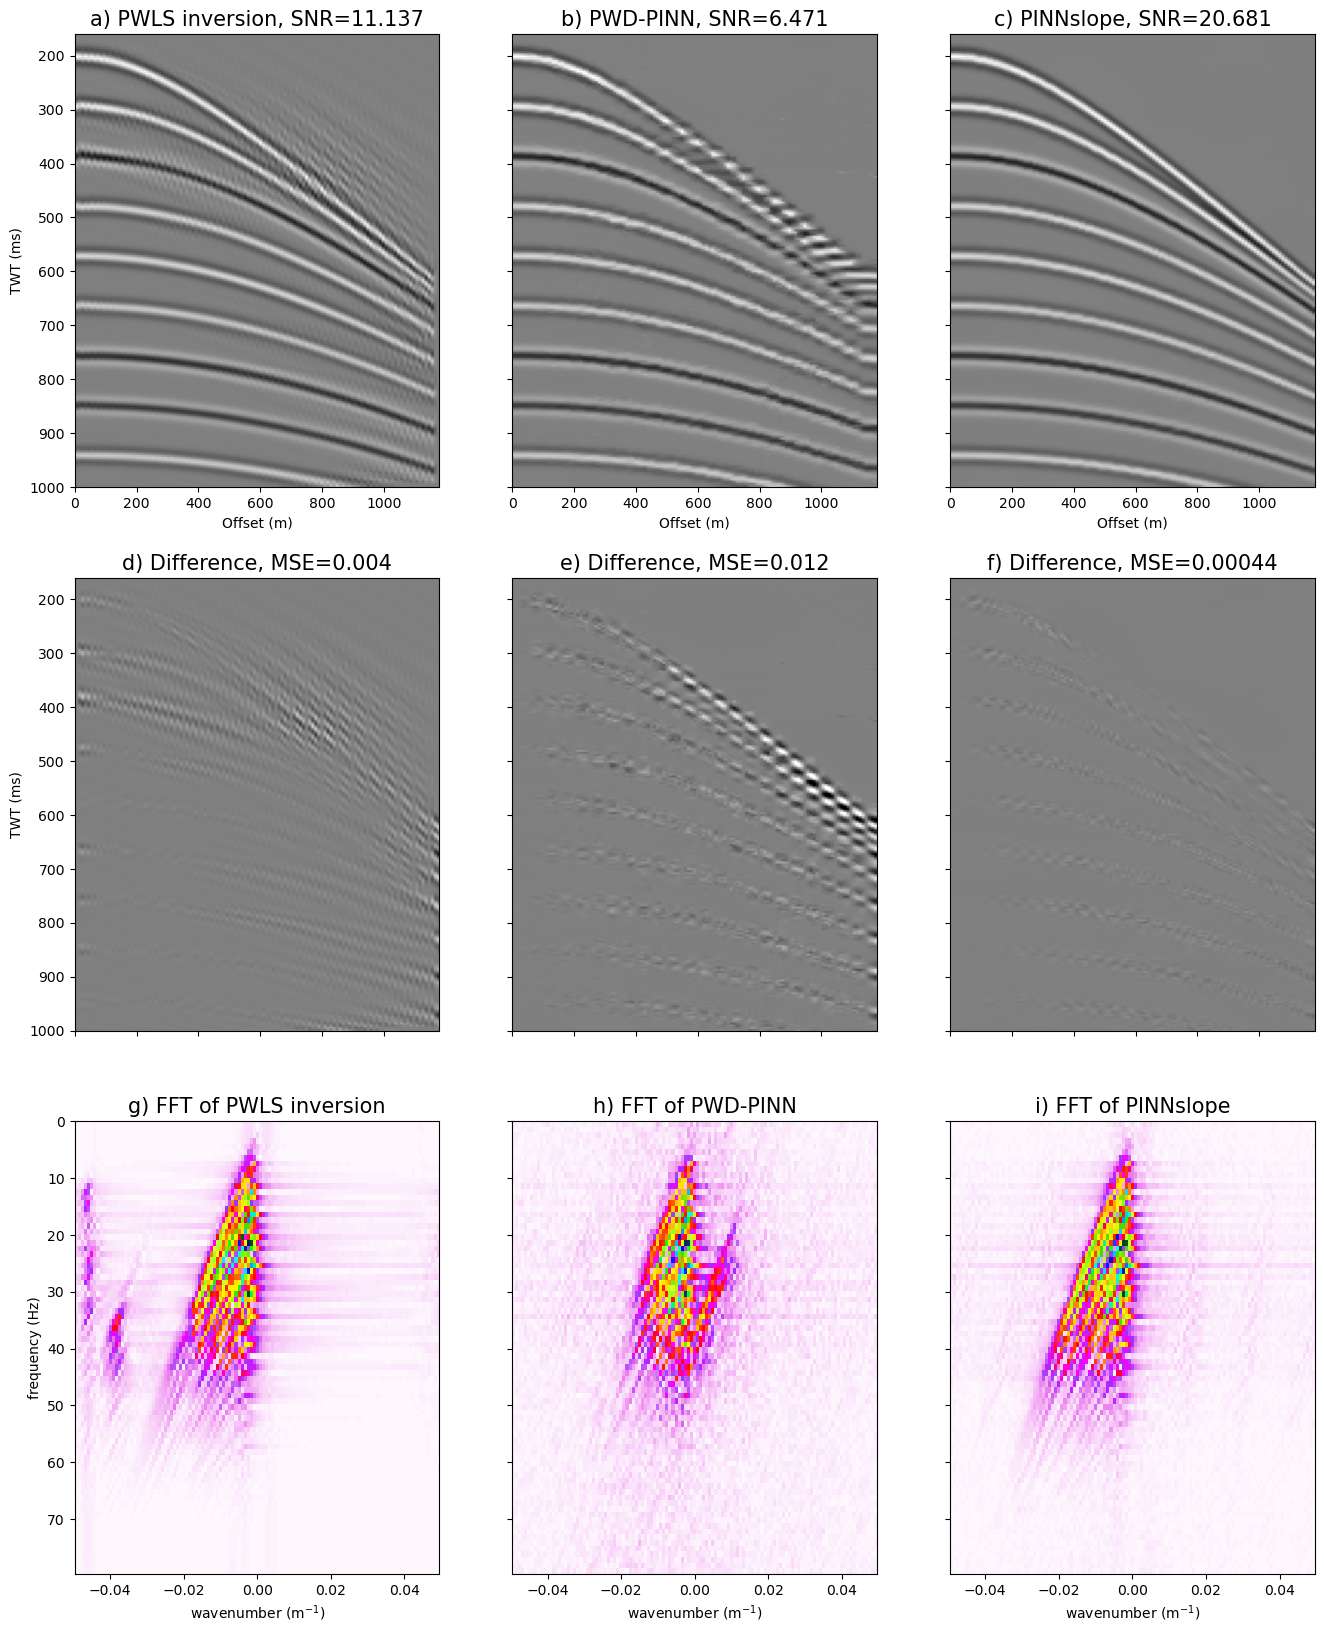

In [10]:
FFTLS = np.fft.fft2(LSinv.T[:,:]); FFTPWD = np.fft.fft2(pwdout[:,:]); FFTuDouble = np.fft.fft2(doubleout.T[:,:])

fig, axs = plt.subplots(3, 3, figsize=(16, 20)) 
limit_plot = 80
vmin=-1; vmax=1

OUT=axs[0][0].imshow(LSinv.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0][0].set_xlabel('Offset (m)')
axs[0][0].set_ylabel('TWT (ms)')
axs[0][0].set_title('a) PWLS inversion, SNR={}'.format( round(snr(data, LSinv),3) ) , fontsize=15)
axs[0][0].axis('tight')

DIFF=axs[0][1].imshow(pwdout, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0][1].set_xlabel('Offset (m)')
axs[0][1].set_title('b) PWD-PINN, SNR={}'.format( round(snr(data.T, pwdout),3) ) , fontsize=15)
axs[0][1].set_yticklabels([])
axs[0][1].axis('tight')

DIFF=axs[0][2].imshow(doubleout.T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[0][2].set_xlabel('Offset (m)')
axs[0][2].set_title('c) PINNslope, SNR={}'.format( round(snr(data, doubleout),3) ) , fontsize=15)
axs[0][2].set_yticklabels([])
axs[0][2].axis('tight')


OUT=axs[1][0].imshow((data-LSinv).T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[1][0].set_ylabel('TWT (ms)')
axs[1][0].set_title('d) Difference, MSE={}'.format( round(mse(data, LSinv),3) ) , fontsize=15)
axs[1][0].set_xticklabels([])
axs[1][0].axis('tight')

DIFF=axs[1][1].imshow((data.T-pwdout), cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[1][1].set_title('e) Difference, MSE={}'.format( round(mse(data.T, pwdout),3) ) , fontsize=15)
axs[1][1].set_yticklabels([])
axs[1][1].set_xticklabels([])
axs[1][1].axis('tight')

DIFF=axs[1][2].imshow((data-doubleout).T, cmap='gray', vmin=vmin, vmax=vmax, extent=(x[0,0], x[-1,-1], t[-1,-1], t[0,0]))
axs[1][2].set_title('f) Difference, MSE={}'.format( round(mse(data, doubleout),5) ) , fontsize=15)
axs[1][2].set_yticklabels([])
axs[1][2].set_xticklabels([])
axs[1][2].axis('tight')


axs[2][0].imshow(np.fft.fftshift(np.abs(FFTLS[:limit_plot]), axes=1),cmap='gist_ncar_r', vmin=0, vmax=400, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[2][0].set_ylabel('frequency (Hz)')
axs[2][0].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)',)
axs[2][0].set_title('g) FFT of PWLS inversion', fontsize=15)
axs[2][0].axis('tight')

axs[2][1].imshow(np.fft.fftshift(np.abs(FFTPWD[:limit_plot]) , axes=1),cmap='gist_ncar_r', vmin=0, vmax=400, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[2][1].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)',)
axs[2][1].set_title('h) FFT of PWD-PINN', fontsize=15)
axs[2][1].set_yticklabels([])
axs[2][1].axis('tight')

axs[2][2].imshow(np.fft.fftshift(np.abs(FFTuDouble[:limit_plot]), axes=1),cmap='gist_ncar_r', vmin=0, vmax=400, extent=(np.fft.fftshift(kx)[0], np.fft.fftshift(kx)[-1],f[limit_plot], f[0]))
axs[2][2].set_xlabel('wavenumber ($\mathregular{m^{-1}}$)',)
axs[2][2].set_title('i) FFT of PINNslope', fontsize=15)
axs[2][2].set_yticklabels([])
axs[2][2].axis('tight')
#plt.savefig('/home/brandof/Documents/VSRP_project/Figs/synth/synthresults.eps', dpi=150, bbox_inches='tight')
plt.show()

### Losses plot

In [12]:
# Plotting the Loss:  
Slossphy = np.load('../data/Results/SynthResults/lossesPWDPINN/lossphy.npy')
Slossdata = np.load('../data/Results/SynthResults/lossesPWDPINN/lossdata.npy')
Slosstot = np.load('../data/Results/SynthResults/lossesPWDPINN/losstot.npy')

SDlossphy = np.load('../data/Results/SynthResults/lossesDoublePINN/lossphy.npy')
SDlossdata = np.load('../data/Results/SynthResults/lossesDoublePINN/lossdata.npy')
SDlosstot = np.load('../data/Results/SynthResults/lossesDoublePINN/losstot.npy')


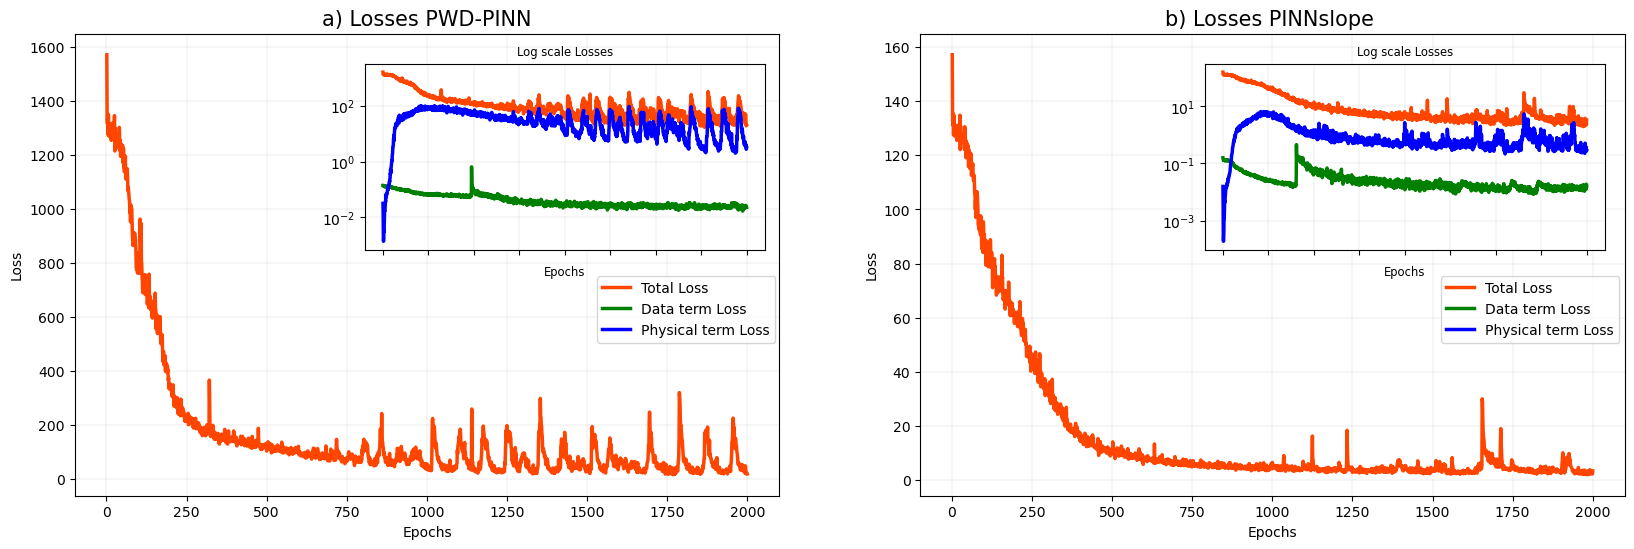

In [13]:

fig, axs = plt.subplots(1, 2, figsize=(20,6))

epochs1 = 2000; epochs_axis1 = np.linspace(1, epochs1, epochs1)
left, bottom, width, height = [0.27, 0.52, 0.2, 0.31]
ax = fig.add_axes([left, bottom, width, height])

ax.plot(epochs_axis1, Slosstot, '-', color='orangered', linewidth=2.5)
ax.plot(epochs_axis1, Slossdata, '-', color='green', linewidth=2.5)
ax.plot(epochs_axis1, Slossphy, '-', color='blue', linewidth=2.5)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('Epochs', fontsize='small')
ax.set_yscale('log')
ax.set_title('Log scale Losses', fontsize='small')
ax.grid(color='grey', linestyle='-', linewidth=0.1)

axs[0].plot(epochs_axis1, Slosstot, '-', color='orangered', linewidth=2.5)
ax.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'], loc=( 0.58, -0.5)) # loc = 'upper right')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('a) Losses PWD-PINN', fontsize=15)
axs[0].grid(color='grey', linestyle='-', linewidth=0.1)


epochs2 = 2000; epochs_axis2 = np.linspace(1, epochs2, epochs2)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left2, bottom2, width2, height2 = [0.69, 0.52, 0.20, 0.31]
ax2 = fig.add_axes([left2, bottom2, width2, height2])

ax2.plot(epochs_axis2, SDlosstot, '-', color='orangered', linewidth=2.5)
ax2.plot(epochs_axis2, SDlossdata, '-', color='green', linewidth=2.5)
ax2.plot(epochs_axis2, SDlossphy, '-', color='blue', linewidth=2.5)

ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xlabel('Epochs', fontsize='small')
ax2.set_yscale('log')
ax2.set_title('Log scale Losses', fontsize='small')
ax2.grid(color='grey', linestyle='-', linewidth=0.1)

axs[1].plot(epochs_axis2, SDlosstot, '-', color='orangered', linewidth=2.5)
ax2.legend(['Total Loss ', 'Data term Loss', 'Physical term Loss'],loc=( 0.59, -0.5)) # loc = 'upper right')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('b) Losses PINNslope ', fontsize=15)
axs[1].grid(color='grey', linestyle='-', linewidth=0.1)

#plt.savefig('/home/brandof/Documents/VSRP_project/Figs/synth/losssynth.eps', dpi=150, format='eps', bbox_inches='tight')
plt.show()

### Plotting the slope estimated by the PINN against the standard PWD

In [14]:
pinnslope = np.load('../data/Results/SynthResults/slopeDoublePINNout.npy');print('pinnslope',pinnslope.shape)
pwdslopeHF = np.load('../data/PWD_Madagascar/synthdenseslope.npy');print(pwdslopeHF.shape)
pwdslopeHF = (dim_x/dim_t)*pwdslopeHF; print('pwdslopeHF',pwdslopeHF.shape)

if crop==True:
    
    # Defining crop params:    
    x_start=0; x_end=119; t_start=40; t_end=251
    pwdslopeHF = pwdslopeHF[ x_start:x_end, t_start:t_end ]; print(pwdslopeHF.shape)

pinnslope (211, 119)
(201, 401)
pwdslopeHF (201, 401)
(119, 211)


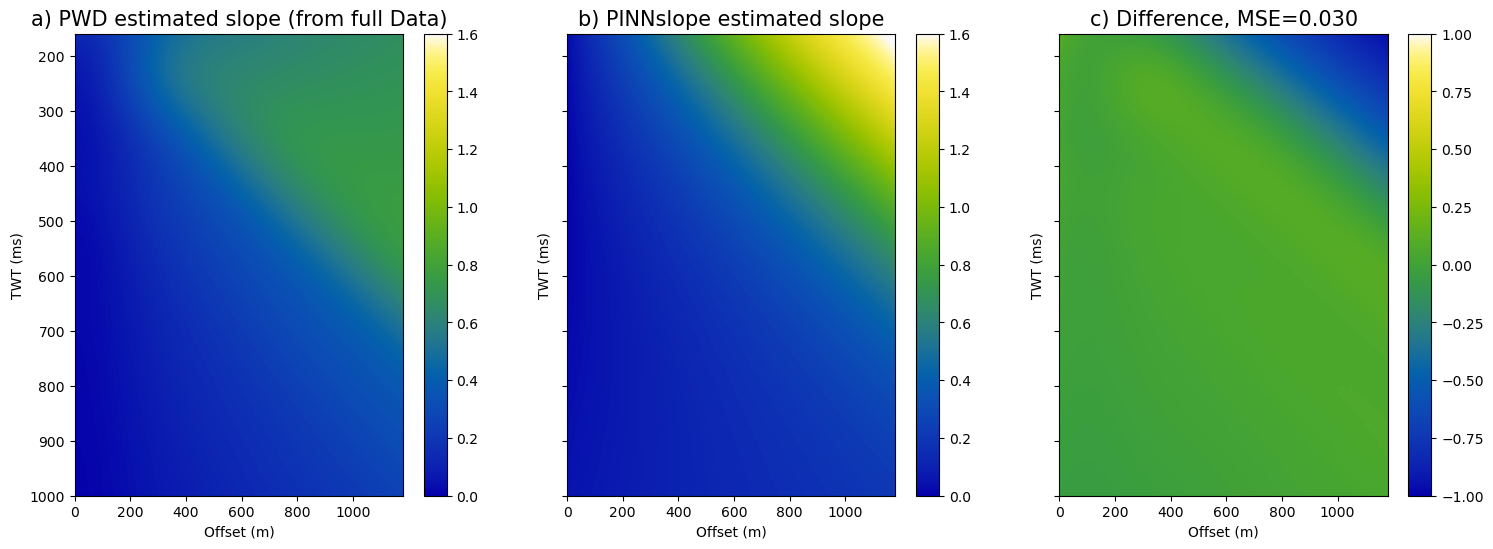

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))

pwdHF=axs[0].imshow(pwdslopeHF.T, cmap=cc.m_linear_bgyw_20_98_c66,vmin=0,vmax=1.6, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[0].set_xlabel('Offset (m)')
axs[0].set_ylabel('TWT (ms)')
axs[0].set_title('a) PWD estimated slope (from full Data)',fontsize=15)
fig.colorbar(pwdHF, ax=axs[0])
axs[0].axis('tight')

Pinnslope=axs[1].imshow(pinnslope, cmap=cc.m_linear_bgyw_20_98_c66,vmin=0,vmax=1.6, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[1].set_xlabel('Offset (m)')
axs[1].set_ylabel('TWT (ms)')
axs[1].set_title('b) PINNslope estimated slope',fontsize=15)
fig.colorbar(Pinnslope, ax=axs[1])
axs[1].set_yticklabels([])
axs[1].axis('tight')

diffslope=axs[2].imshow((pwdslopeHF.T-pinnslope), cmap=cc.m_linear_bgyw_20_98_c66, vmin=-1, vmax=-vmin, extent=(x[0, 0], x[-1, -1], t[-1, -1], t[0, 0]))
axs[2].set_xlabel('Offset (m)')
axs[2].set_ylabel('TWT (ms)')
mse_slope=round(mse(pinnslope, pwdslopeHF.T),4)
axs[2].set_title('c) Difference, MSE=%.3f' %( mse_slope ) , fontsize=15)
fig.colorbar(diffslope, ax=axs[2])
axs[2].set_yticklabels([])
axs[2].axis('tight')

#plt.savefig('/home/brandof/Documents/VSRP_project/Figs/synth/synthPINNslope.eps', dpi=150, format='eps', bbox_inches='tight')
plt.show()
